# StreamMultiDiffusion Multi-Prompt Image Inpainting with Prompt Separation Demo

For additional info, please consult our paper: [StreamMultiDiffusion: Real-Time Interactive Generation with Region-Based Semantic Control](https://arxiv.org/abs/2403.09055).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ironjr/StreamMultiDiffusion
!pip install -r StreamMultiDiffusion/requirements.txt

Cloning into 'StreamMultiDiffusion'...
remote: Enumerating objects: 841, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 841 (delta 267), reused 240 (delta 159), pack-reused 459
Receiving objects: 100% (841/841), 270.51 MiB | 40.63 MiB/s, done.
Resolving deltas: 100% (440/440), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 85.0 MB/s eta 0:0

## Preparation

In [1]:
seed = 4242
device = 0

In [2]:
import sys
import time
import warnings

sys.path.append('StreamMultiDiffusion/src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from functools import reduce

from util import seed_everything, blend
from model import StableMultiDiffusionSDXLPipeline
from ipython_util import dispt


seed_everything(seed)
device = f'cuda:{device}'
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

2024-05-10 07:59:03.946902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 07:59:03.946957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 07:59:03.949009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 07:59:05.276645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[INFO] Initialized with seed  : 4242
[INFO] Initialized with device: cuda:0


## Background image to inpaint

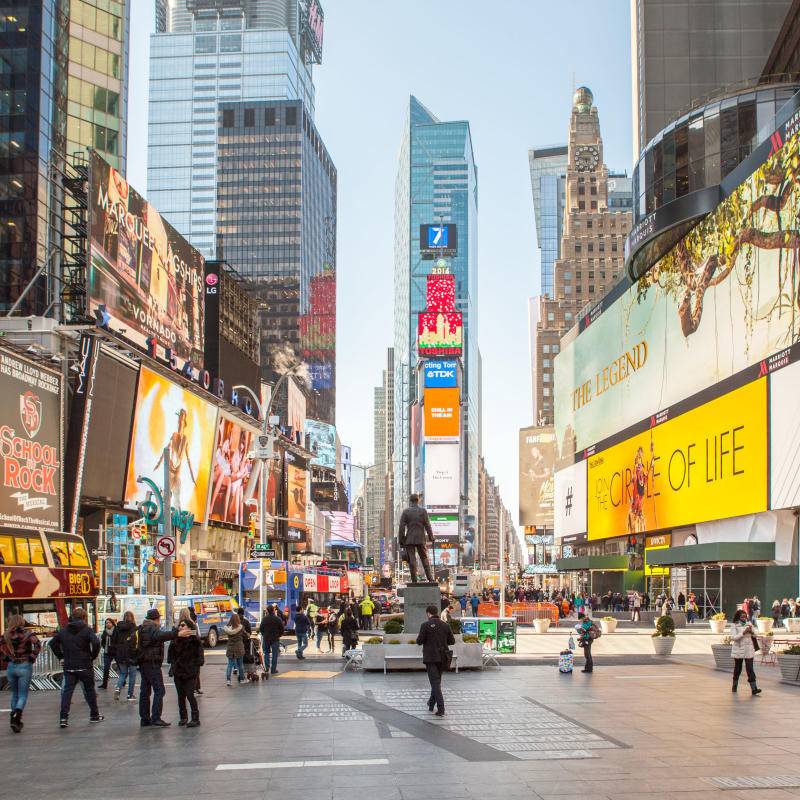

In [3]:
background_image = Image.open('StreamMultiDiffusion/assets/timessquare/timessquare.jpeg')
display(background_image)

# Run

## Step 1: Load a StreamMultiDiffusion pipeline.

In [4]:
smd = StableMultiDiffusionSDXLPipeline(
    device
)

[INFO] Loading Stable Diffusion...
drive/MyDrive/checkpoints/john_cena_last.ckpt


Some weights of the model checkpoint were not used when initializing CLIPTextModelWithProjection: 
 ['text_model.embeddings.position_ids']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Model is loaded!


## Step 2: Load *semantic palette*, i.e., prompts and masks.

The differences of this inpainting example with the generation example in `demo_simple.ipynb` are summarized as:

1. In the inpainting mode, we do not explicitly specify background mask. It is calculated in the module.
2. In the inpainting mode, the `background_prompt` and the `background_negative_prompt` are explicitly specified. However, such prompts are not necessary since we use BLIP-2 model internally to estimate the background prompt from the background image.
3. The call of the module receives additional arguments of `background` for background image, in addition to the optional `background_prompt` and `background_negative_prompt`.

[INFO] Loading masks...


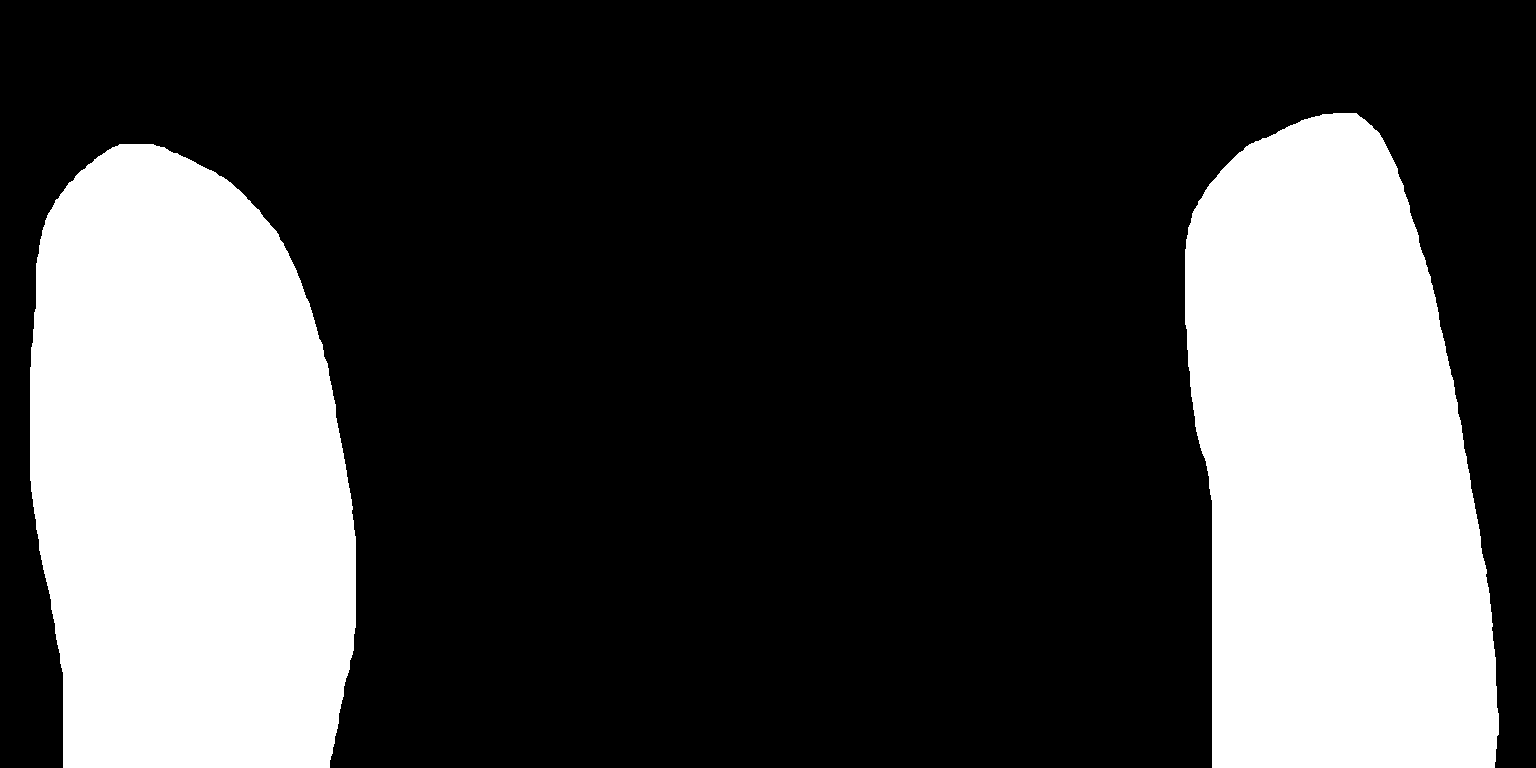

[INFO] Loading prompts...
Background Prompt: 2 men standing at times square
Background Negative Prompt: worst quality, bad quality, normal quality, cropped, framed
Prompt0: John Cena, looking at viewer
Prompt1: John Cena, looking at viewer
Negative Prompt0: worst quality, bad quality, normal quality, cropped, framed, 1girl
Negative Prompt1: worst quality, bad quality, normal quality, cropped, framed, 1boy


In [5]:
# Prepare masks.
print('[INFO] Loading masks...')

name = 'timessquare'
mask_all = Image.open(f'StreamMultiDiffusion/assets/{name}/{name}_full.png').convert('RGBA')
masks = [Image.open(f'StreamMultiDiffusion/assets/{name}/{name}_{i}.png').convert('RGBA') for i in range(1, 3)]
masks = [(T.ToTensor()(mask)[-1:] > 0.5).float() for mask in masks]
# Background mask is not explicitly specified in the inpainting mode.
dispt(masks, row=1)

masks = torch.stack(masks, dim=0)

# Prepare prompts.
print('[INFO] Loading prompts...')

background_prompt = '2 men standing at times square'
prompts = [
    # Foreground prompts.
    'John Cena, looking at viewer',
    'John Cena, looking at viewer',
]
negative_prompts = [
    '1girl',
    '1boy',
]
negative_prompt_prefix = 'worst quality, bad quality, normal quality, cropped, framed'
negative_prompts = [negative_prompt_prefix + ', ' + p for p in negative_prompts]
background_negative_prompt = negative_prompt_prefix

print('Background Prompt: ' + background_prompt)
print('Background Negative Prompt: ' + background_negative_prompt)
for i, prompt in enumerate(prompts):
    print(f'Prompt{i}: ' + prompt)
for i, prompt in enumerate(negative_prompts):
    print(f'Negative Prompt{i}: ' + prompt)

height, width = masks.shape[-2:]

## Step 3: Generate a large-scale image from multiple (9!) text prompts in a minute!

### Main generation routine

PROMPTS GIVEN
['John Cena, looking at viewer', 'John Cena, looking at viewer']
['2 men standing at times square', 'John Cena, looking at viewer', 'John Cena, looking at viewer']
PROMPT EMBEDS 1
torch.Size([3, 77, 2048])


  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([1, 4, 96, 96])
LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


  2%|▎         | 1/40 [00:04<02:53,  4.45s/it]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


  5%|▌         | 2/40 [00:04<01:19,  2.08s/it]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


  8%|▊         | 3/40 [00:05<00:49,  1.33s/it]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 10%|█         | 4/40 [00:05<00:34,  1.03it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 12%|█▎        | 5/40 [00:06<00:27,  1.29it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 15%|█▌        | 6/40 [00:06<00:22,  1.52it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 18%|█▊        | 7/40 [00:07<00:19,  1.72it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 20%|██        | 8/40 [00:07<00:16,  1.89it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 22%|██▎       | 9/40 [00:07<00:15,  2.01it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 25%|██▌       | 10/40 [00:08<00:14,  2.10it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 28%|██▊       | 11/40 [00:08<00:13,  2.18it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 30%|███       | 12/40 [00:09<00:12,  2.23it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 32%|███▎      | 13/40 [00:09<00:11,  2.28it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 35%|███▌      | 14/40 [00:09<00:11,  2.30it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 38%|███▊      | 15/40 [00:10<00:10,  2.32it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 40%|████      | 16/40 [00:10<00:10,  2.33it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 42%|████▎     | 17/40 [00:11<00:09,  2.34it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 45%|████▌     | 18/40 [00:11<00:09,  2.35it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 48%|████▊     | 19/40 [00:12<00:08,  2.36it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 50%|█████     | 20/40 [00:12<00:08,  2.36it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 52%|█████▎    | 21/40 [00:12<00:08,  2.37it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 55%|█████▌    | 22/40 [00:13<00:07,  2.37it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 57%|█████▊    | 23/40 [00:13<00:07,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 60%|██████    | 24/40 [00:14<00:06,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 62%|██████▎   | 25/40 [00:14<00:06,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 65%|██████▌   | 26/40 [00:15<00:05,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 68%|██████▊   | 27/40 [00:15<00:05,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 70%|███████   | 28/40 [00:15<00:05,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 72%|███████▎  | 29/40 [00:16<00:04,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 75%|███████▌  | 30/40 [00:16<00:04,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 78%|███████▊  | 31/40 [00:17<00:03,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 80%|████████  | 32/40 [00:17<00:03,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 82%|████████▎ | 33/40 [00:17<00:02,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 85%|████████▌ | 34/40 [00:18<00:02,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 88%|████████▊ | 35/40 [00:18<00:02,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 90%|█████████ | 36/40 [00:19<00:01,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 92%|█████████▎| 37/40 [00:19<00:01,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 95%|█████████▌| 38/40 [00:20<00:00,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


 98%|█████████▊| 39/40 [00:20<00:00,  2.38it/s]

LATENT INPUT
torch.Size([2, 4, 96, 96])
PROMPT EMBEDS
torch.Size([2, 77, 2048])
ADD TEXT
torch.Size([2, 1280])
ADD TIME
torch.Size([2, 6])


100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Elapsed Time: 37.668455600738525


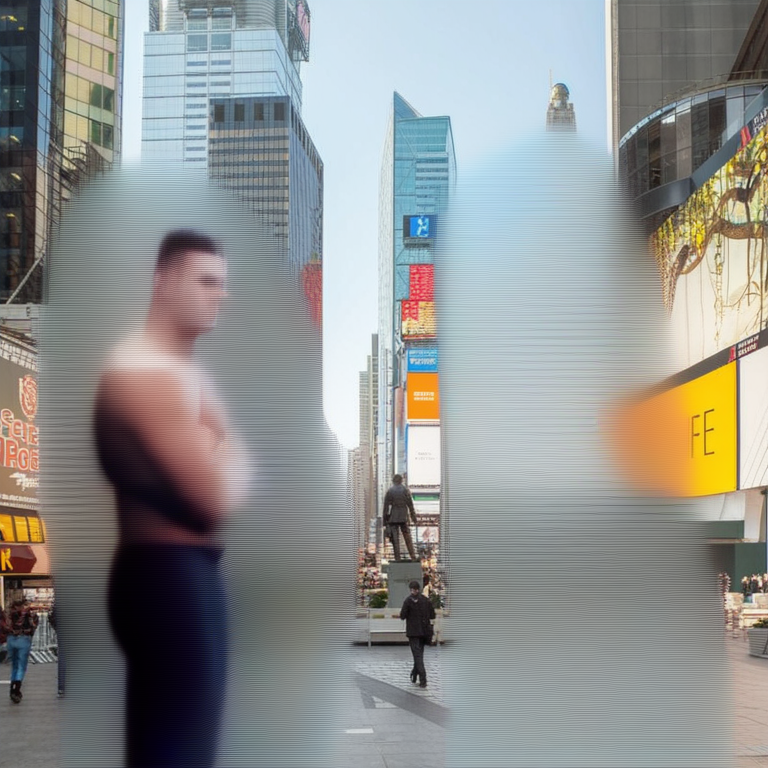

In [6]:
tic = time.time()
img = smd(
    prompts,
    negative_prompts,
    masks=masks.float(),
    # Use larger standard deviation to harmonize the inpainting result!
    mask_stds=16.0,
    mask_strengths=1.0,
    height=height,
    width=width,
    bootstrap_steps=1,
    bootstrap_leak_sensitivity=0.5,
    boostrap_mix_steps=0.1,
    do_blend=False,
    # This is for providing the image input.|
    background=background_image,
    background_prompt=background_prompt,
    background_negative_prompt=background_negative_prompt,
    num_inference_steps = 40
)
toc = time.time()
print(f'Elapsed Time: {toc - tic}')
display(img)